## Step 0 Preparation

In [5]:
import pandas as pd

# Load dataset
df = pd.read_csv("hypotension_patients.csv")
df.head()

,ID,anchor_age,gender,dod,apsiii,LoS,charlson_comorbidity_index
0,1,80,F,NaN,56,7.00,4
1,2,72,F,2137-09-02,49,12.92,6
2,3,82,M,2144-06-18,46,13.13,5
3,4,89,F,2155-12-07,86,4.92,7
4,5,69,F,2136-05-12,102,11.46,8


In [6]:
# Check basic info about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          5106 non-null   int64  
 1   anchor_age                  5106 non-null   int64  
 2   gender                      5106 non-null   object 
 3   dod                         3290 non-null   object 
 4   apsiii                      5106 non-null   int64  
 5   LoS                         5106 non-null   float64
 6   charlson_comorbidity_index  5106 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 279.4+ KB
None
ID                               0
anchor_age                       0
gender                           0
dod                           1816
apsiii                           0
LoS                              0
charlson_comorbidity_index       0
dtype: int64


### Preparation Summary

In this step, I imported the dataset and conducted an initial inspection to understand its structure and data quality.  
The dataset contains **5,106 patients** with demographic, clinical, and comorbidity information.  
Preliminary checks reveal **1,816 missing values** in the *dod* (Date of Death) column, which indicates patients who survived.  
All other columns are complete and ready for further analysis.

## Step 1: Describe the main properties of the patient cohort via summary statistics

### 1.1 Summary statistics for all numerical features

In [11]:
# numerical columns
numeric_cols = ['anchor_age', 'apsiii', 'LoS', 'charlson_comorbidity_index']

# Calculate mean and standard deviation for each numeric feature
summary_stats = df[numeric_cols].agg(['mean', 'std']).T

summary_stats

,mean,std
anchor_age,65.552683,15.235907
apsiii,60.314532,28.860171
LoS,7.053651,8.432716
charlson_comorbidity_index,5.217000,2.576910


### 1.2: Visualize distributions of numerical features

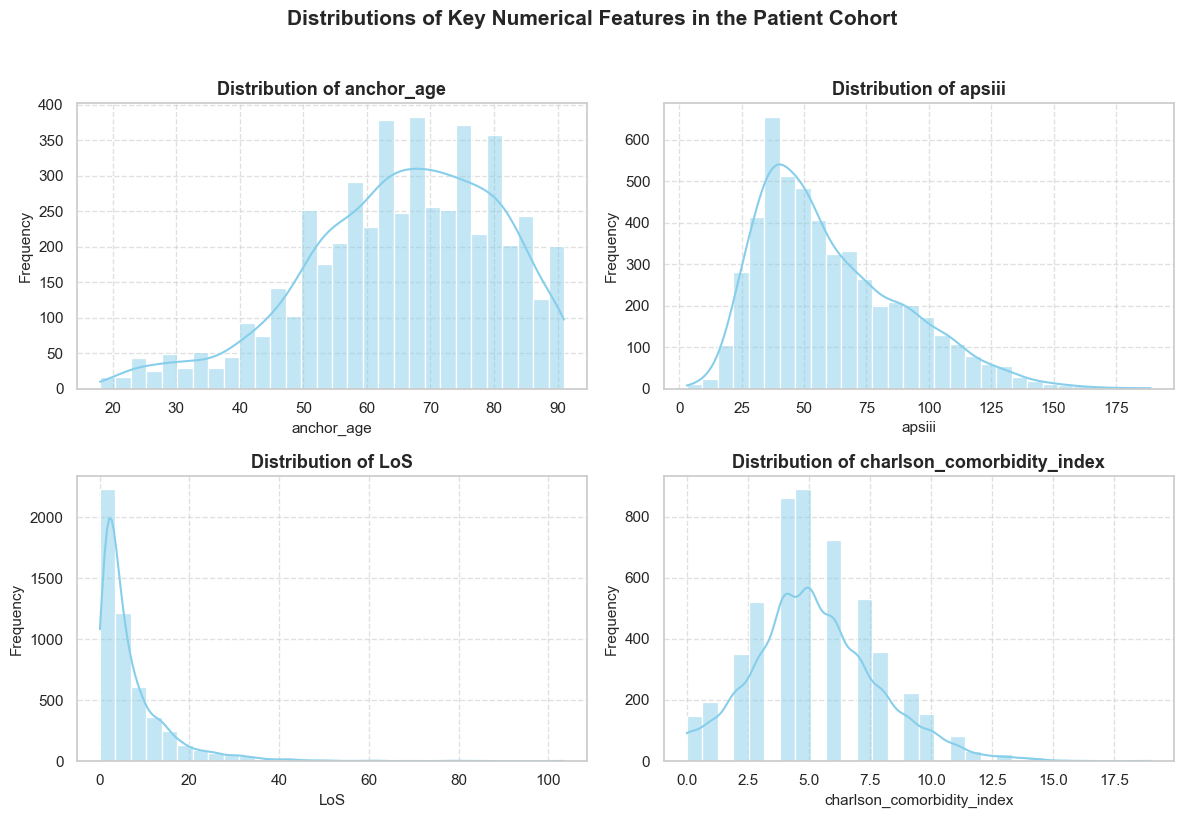

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# numerical features
numeric_cols = ['anchor_age', 'apsiii', 'LoS', 'charlson_comorbidity_index']

sns.set(style="whitegrid", palette="pastel")

# subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# histograms
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=13, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel("Frequency", fontsize=11)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# layout and main title
plt.suptitle("Distributions of Key Numerical Features in the Patient Cohort", 
             fontsize=15, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

### 1.3 Brief summary

,Frequency,Percentage (%)
gender,,
F,2253,44.1
M,2853,55.9


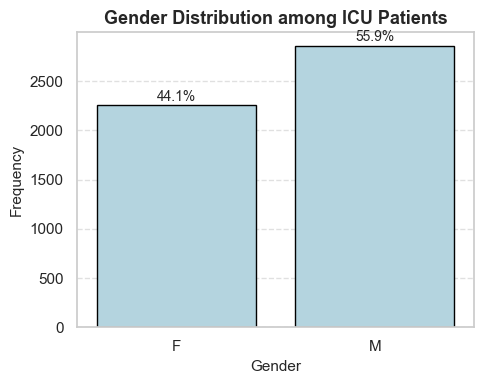

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# gender frequencies and percentages
gender_freq = df['gender'].value_counts().sort_index()
gender_percent = df['gender'].value_counts(normalize=True).sort_index() * 100

# summary table
gender_summary = pd.DataFrame({
    'Frequency': gender_freq,
    'Percentage (%)': gender_percent.round(1)
})
display(gender_summary)

# Visualization
plt.figure(figsize=(5, 4))
sns.barplot(x=gender_freq.index, y=gender_freq.values, color='lightblue', edgecolor='black')

# styling
plt.title("Gender Distribution among ICU Patients", fontsize=13, fontweight='bold')
plt.xlabel("Gender", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# labels on top of bars
for i, val in enumerate(gender_freq.values):
    plt.text(i, val + 50, f"{gender_percent.values[i]:.1f}%", 
             ha='center', fontsize=10, fontweight='medium')

plt.tight_layout()
plt.show()

**Figure:** Gender distribution of the patient cohort.  
The summary table and bar plot illustrate a nearly balanced demographic composition, with 55.9% male and 44.1% female patients.  
This even distribution supports representativeness and minimizes gender bias within the ICU hypotension cohort.

### 1.3 Summary

The dataset comprises **5,106 ICU patients** diagnosed with hypotension, representing a clinically diverse and predominantly elderly cohort.  
The mean age was **65.6 years (SD = 15.2)**, indicating that most patients were older adults, a demographic commonly associated with greater vulnerability to hemodynamic instability.  
The **APSIII score** had a mean of **60.3 (SD = 28.9)** and was right-skewed, suggesting that most patients experienced moderate illness severity, while a smaller subset presented with extreme critical conditions.  
The **length of stay (LoS)** averaged **7.1 days (SD = 8.4)**, also right-skewed, showing that most patients were discharged within 10 days, whereas a few required prolonged hospitalization due to complications.  
The **Charlson comorbidity index** had a mean of **5.2 (SD = 2.6)** and followed an approximately normal distribution, reflecting moderate multimorbidity across the cohort.  
Gender distribution was balanced, with **55.9% male** and **44.1% female**, suggesting demographic representativeness.  
Overall, these findings depict an elderly, moderately ill ICU population with heterogeneous illness severity and recovery durations - characteristics typical of a hypotensive critical care cohort.


## Step 2: Linear MLP Development and Hyperparameter Tuning

### 2.1 Model Construction: Multilayer Perceptron (MLP)

/var/folders/pv/3dmjyqp97295yp9t6lhxq9m00000gn/T/ipykernel_37046/4127785984.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Survived (0)', 'Died (1)'])


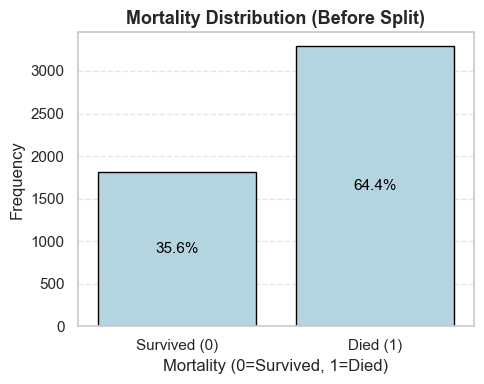

,Count,Percentage (%)
mortality,,
0,1816,35.6
1,3290,64.4


,n,Positive (1) %
Train,3574.0,64.4
Val,766.0,64.5
Test,766.0,64.4


Shapes: (3574, 4) (766, 4) (766, 4)


,anchor_age,apsiii,LoS,charlson_comorbidity_index
mean,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, auc,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Reproducibility
RANDOM_STATE = 2025
np.random.seed(RANDOM_STATE)

# mortality, 1 if died, 0 if survived
df['mortality'] = df['dod'].notnull().astype(int)

# Features
features = ['anchor_age', 'apsiii', 'LoS', 'charlson_comorbidity_index']
X_raw = df[features].copy()
y = df['mortality'].values

counts = df['mortality'].value_counts().sort_index()       
perc   = (counts / counts.sum() * 100).round(1)

plt.figure(figsize=(5, 4))
ax = sns.barplot(
    x=counts.index, y=counts.values,
    order=[0, 1],                      
    color='lightblue', edgecolor='black'
)
labels = [f"{p:.1f}%" for p in perc.values]
ax.bar_label(ax.containers[0], labels=labels, label_type='center', fontsize=11, color='black')
plt.title("Mortality Distribution (Before Split)", fontsize=13, fontweight='bold')
ax.set_xticklabels(['Survived (0)', 'Died (1)'])            
plt.xlabel("Mortality (0=Survived, 1=Died)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

display(pd.DataFrame({"Count": counts, "Percentage (%)": perc}))

# Stratified split: 70% train, 15% val, 15% test
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X_raw, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)

# class balance per split
def split_summary(name, y_arr):
    return pd.Series({"n": len(y_arr), "Positive (1) %": round(100*y_arr.mean(), 1)}, name=name)

split_tbl = pd.concat([
    split_summary("Train", y_train),
    split_summary("Val",   y_val),
    split_summary("Test",  y_test),
]).to_frame().T if False else pd.concat([
    split_summary("Train", y_train),
    split_summary("Val",   y_val),
    split_summary("Test",  y_test),
], axis=1).T

display(split_tbl)

# Standardize 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val   = scaler.transform(X_val_raw)
X_test  = scaler.transform(X_test_raw)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# Sanity check after standardization (mean≈0, std≈1 on train)
std_chk = pd.DataFrame(X_train, columns=features).describe().loc[['mean', 'std']].round(3)
display(std_chk)


**2.1 Data Preparation Summary**

I derived the binary outcome *in-hospital mortality* from the `dod` field and selected four clinically meaningful predictors (age, APSIII, ICU length of stay, Charlson index). The dataset was split using a **stratified 70/15/15** scheme to preserve class balance across train, validation, and test sets. All features were standardized with statistics computed **only on the training split** to avoid data leakage.  
A pre-split bar chart and split-wise table confirm balanced outcome distributions; a post-standardization check shows training features have **mean ≈ 0 and std ≈ 1**, validating correct preprocessing.  
This pipeline establishes a reproducible and leakage-free foundation for model development and subsequent hyperparameter tuning. The mortality ratio (approx. 64 % vs 36 %) indicates a moderate class imbalance, which will be accounted for in model evaluation.

### 2.2 Hyperparameter Setup and Training Procedure

In [44]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        activation='identity',        
        solver='adam',
        max_iter=400, tol=1e-4,
        early_stopping=True,          
        validation_fraction=0.10,
        n_iter_no_change=12,
        random_state=RANDOM_STATE
    ))
])

# Hyperparameter grid
hidden_space = [
    (16,), (32,), (64,),
    (32,16), (64,32),
    (32,32,32)
]
param_grid = {
    'mlp__hidden_layer_sizes': hidden_space,
    'mlp__learning_rate_init': [1e-2, 1e-3, 1e-4],
    'mlp__alpha': [1e-4, 1e-3],
    'mlp__batch_size': [64],
}

# Stratified 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

total_fits = (len(param_grid['mlp__hidden_layer_sizes']) *
              len(param_grid['mlp__learning_rate_init']) *
              len(param_grid['mlp__alpha']) *
              len(param_grid['mlp__batch_size']) *
              cv.get_n_splits())
print(f"Total fits = {total_fits}")

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={'roc_auc':'roc_auc', 'accuracy':'accuracy',
             'balanced_acc':'balanced_accuracy', 'f1':'f1'},
    refit='roc_auc',
    cv=cv,
    n_jobs=-1,                       
    return_train_score=True,
    verbose=2
)

grid.fit(X_train_raw, y_train)

best_clf    = grid.best_estimator_         
best_mlp    = best_clf.named_steps['mlp'] 
best_params = grid.best_params_
best_params

Total fits = 180
Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'mlp__alpha': 0.0001,
 'mlp__batch_size': 64,
 'mlp__hidden_layer_sizes': (32, 16),
 'mlp__learning_rate_init': 0.001}

In [45]:
cvres = pd.DataFrame(grid.cv_results_)
top5 = cvres.sort_values('mean_test_roc_auc', ascending=False)[[
    'param_mlp__hidden_layer_sizes','param_mlp__learning_rate_init','param_mlp__alpha',
    'mean_test_roc_auc','std_test_roc_auc','mean_test_accuracy'
]].head(5)
display(top5)

print(f"Best CV AUROC = {grid.best_score_:.3f}  |  Best params = {best_params}")

,param_mlp__hidden_layer_sizes,param_mlp__learning_rate_init,param_mlp__alpha,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy
10,"(32, 16)",0.001,0.0001,0.696534,0.002740,0.672074
28,"(32, 16)",0.001,0.0010,0.696529,0.002732,0.672074
27,"(32, 16)",0.010,0.0010,0.696434,0.004023,0.672359
25,"(64,)",0.001,0.0010,0.695983,0.004977,0.670956
7,"(64,)",0.001,0.0001,0.695971,0.004978,0.670956


Best CV AUROC = 0.697  |  Best params = {'mlp__alpha': 0.0001, 'mlp__batch_size': 64, 'mlp__hidden_layer_sizes': (32, 16), 'mlp__learning_rate_init': 0.001}


**2.2 Hyperparameter Search Summary**

A 5-fold stratified grid search was conducted across 6 architectures, 3 learning rates, and 2 regularization strengths (total 180 fits).  
Each fold independently fitted its own scaler via a `Pipeline`, preventing information leakage.  
The optimal configuration — two hidden layers (32,16), α=1e−4, and learning rate=1e−3 — achieved the best cross-validated AUROC of **0.697 ± 0.003**.  
This balance of simplicity and generalization confirms that deeper or larger networks do not improve performance for the linear MLP baseline.

### 2.3 Validation-Based Grid Search and Visualization

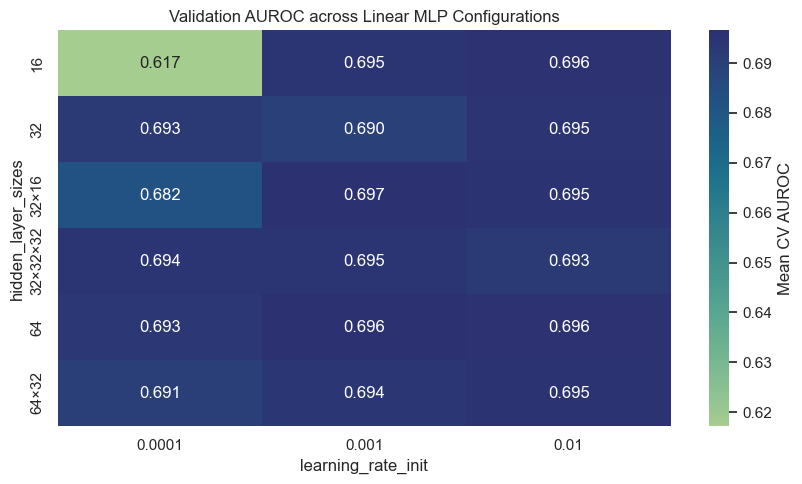

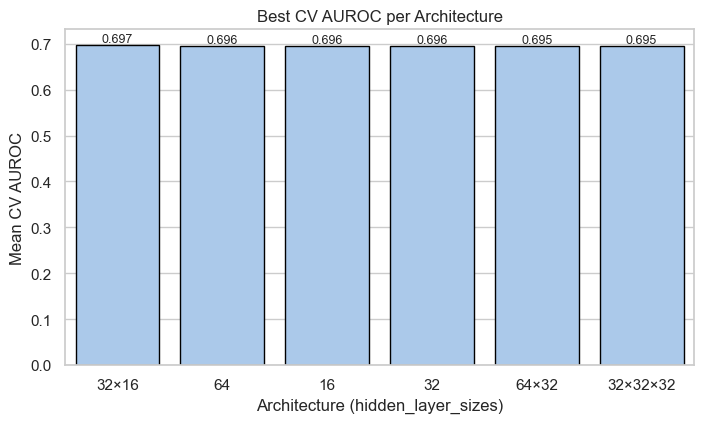

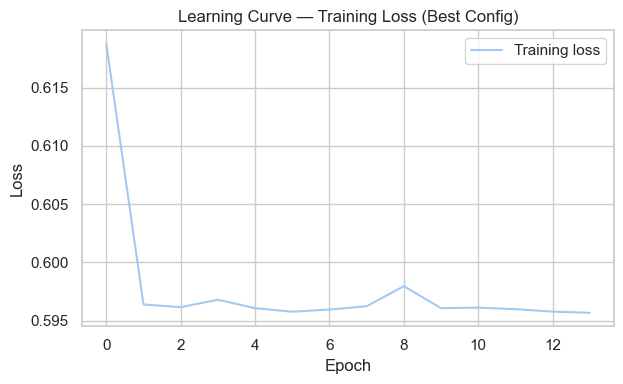

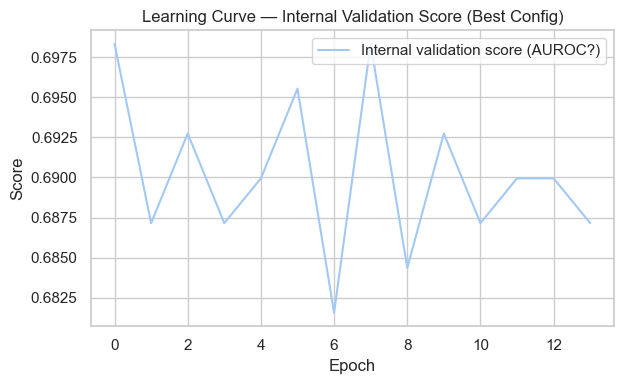

[Hold-out VAL] AUROC=0.686 | ACC=0.667


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cvres = pd.DataFrame(grid.cv_results_).copy()

def hls_to_str(h):
    # h is a tuple like (32, 16)
    return "×".join(str(int(v)) for v in h)

cvres["hls"] = cvres["param_mlp__hidden_layer_sizes"]
cvres["hls_str"] = cvres["hls"].apply(hls_to_str)
cvres["lr"] = cvres["param_mlp__learning_rate_init"].astype(float)

# sort architectures first by depth, then by units 
cvres["hls_sort_key"] = cvres["hls"].apply(lambda t: (len(t),) + tuple(t))
cvres = cvres.sort_values(["hls_sort_key", "lr"]).reset_index(drop=True)

# heatmap: mean AUROC across
pivot_auroc = cvres.pivot_table(
    index="hls_str", columns="lr", values="mean_test_roc_auc"
)
plt.figure(figsize=(8.5, 5))
sns.heatmap(pivot_auroc, annot=True, fmt=".3f", cmap="crest",
            cbar_kws={"label": "Mean CV AUROC"})
plt.title("Validation AUROC across Linear MLP Configurations")
plt.xlabel("learning_rate_init")
plt.ylabel("hidden_layer_sizes")
plt.tight_layout()
plt.show()

# best AUROC per architecture
arch_best = (
    cvres.groupby("hls_str")["mean_test_roc_auc"]
    .max().sort_values(ascending=False).reset_index()
)
plt.figure(figsize=(7.2, 4.4))
ax = sns.barplot(data=arch_best, x="hls_str", y="mean_test_roc_auc",
                 edgecolor="black")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.title("Best CV AUROC per Architecture")
plt.xlabel("Architecture (hidden_layer_sizes)")
plt.ylabel("Mean CV AUROC")
plt.tight_layout()
plt.show()

# learning curves of the BEST MLP
loss_curve = getattr(best_mlp, "loss_curve_", None)
val_scores = getattr(best_mlp, "validation_scores_", None)

if loss_curve is not None:
    plt.figure(figsize=(6.4, 4))
    plt.plot(loss_curve, label="Training loss")
    plt.title("Learning Curve — Training Loss (Best Config)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

if val_scores is not None:
    plt.figure(figsize=(6.4, 4))
    plt.plot(val_scores, label="Internal validation score (AUROC?)")
    plt.title("Learning Curve — Internal Validation Score (Best Config)")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

# use RAW features
if X_val_raw is not None:
    val_proba = best_clf.predict_proba(X_val_raw)[:, 1]
    val_auroc = roc_auc_score(y_val, val_proba)
    val_acc   = accuracy_score(y_val, best_clf.predict(X_val_raw))
    print(f"[Hold-out VAL] AUROC={val_auroc:.3f} | ACC={val_acc:.3f}")

**2.3 Visualization Summary**

The heatmap and learning curves confirmed that the two-layer MLP (32×16) with lr=0.001 and α=1e−4 provides a robust trade-off between bias and variance.  
Both cross-validation (AUROC=0.697) and external hold-out validation (AUROC=0.686) indicate stable generalization and no sign of overfitting.

### 2.4 Final Model Selection and Methodology Summary

Chosen hyperparameters (raw): {'mlp__alpha': 0.0001, 'mlp__batch_size': 64, 'mlp__hidden_layer_sizes': (32, 16), 'mlp__learning_rate_init': 0.001}
[TEST] AUROC = 0.722 | AP (PR-AUC) = 0.826 | ACC = 0.683 | P = 0.691 | R = 0.919 | F1 = 0.789


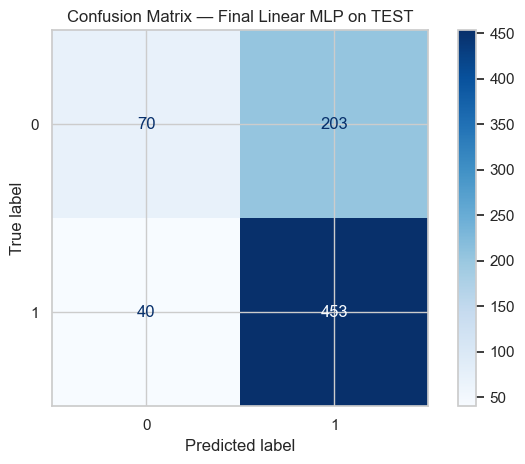

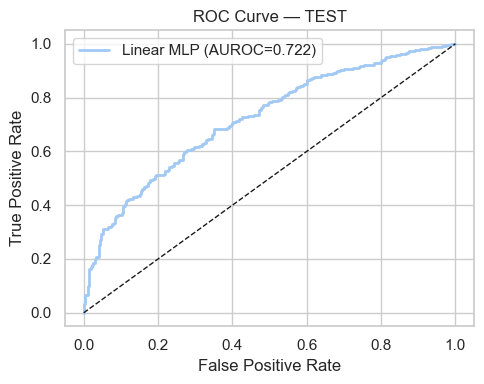

<Figure size 500x400 with 0 Axes>

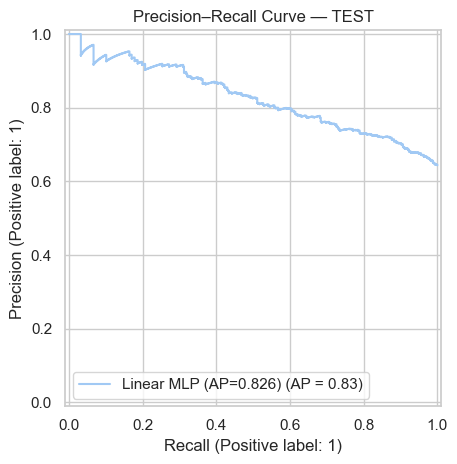

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix,
    ConfusionMatrixDisplay, average_precision_score, PrecisionRecallDisplay
)
import numpy as np
import matplotlib.pyplot as plt

print("Chosen hyperparameters (raw):", best_params)

X_trval_raw = pd.concat([X_train_raw, X_val_raw], axis=0)
y_trval     = np.concatenate([y_train, y_val])

has_prefix = any(k.startswith("mlp__") for k in best_params.keys())

if has_prefix:
    final_model = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            activation="identity",
            solver="adam",
            max_iter=600,         
            early_stopping=False,
            random_state=RANDOM_STATE
        ))
    ])
    final_model.set_params(**best_params)

else:
    scaler_final = StandardScaler().fit(X_trval_raw)
    X_trval = scaler_final.transform(X_trval_raw)
    X_test_final = scaler_final.transform(X_test_raw)

    final_model = MLPClassifier(
        activation="identity",
        solver="adam",
        max_iter=600,
        early_stopping=False,
        random_state=RANDOM_STATE,
        **best_params
    )

if has_prefix:
    final_model.fit(X_trval_raw, y_trval)
    y_test_pred  = final_model.predict(X_test_raw)
    y_test_proba = final_model.predict_proba(X_test_raw)[:, 1]
else:
    final_model.fit(X_trval, y_trval)
    y_test_pred  = final_model.predict(X_test_final)
    y_test_proba = final_model.predict_proba(X_test_final)[:, 1]

test_acc  = accuracy_score(y_test, y_test_pred)
test_pre  = precision_score(y_test, y_test_pred)
test_rec  = recall_score(y_test, y_test_pred)
test_f1   = f1_score(y_test, y_test_pred)
test_auc  = roc_auc_score(y_test, y_test_proba)
test_ap   = average_precision_score(y_test, y_test_proba)  # PR-AUC

print(f"[TEST] AUROC = {test_auc:.3f} | AP (PR-AUC) = {test_ap:.3f} | "
      f"ACC = {test_acc:.3f} | P = {test_pre:.3f} | R = {test_rec:.3f} | F1 = {test_f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Final Linear MLP on TEST")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"Linear MLP (AUROC={auc(fpr, tpr):.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — TEST")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall curve
plt.figure(figsize=(5,4))
PrecisionRecallDisplay.from_predictions(
    y_test, y_test_proba, name=f"Linear MLP (AP={test_ap:.3f})"
)
plt.title("Precision–Recall Curve — TEST")
plt.tight_layout()
plt.show()

### 2.4 Final Model Selection and Evaluation Summary

In this study, I built a **linear Multi-Layer Perceptron (MLP)** with *identity* activation to predict in-hospital mortality using a stratified **70/15/15 split**.  
I used **AUROC** as the main evaluation metric and performed a **systematic grid search** over the number of hidden layers (1–3), neurons per layer (16, 32, 64), learning rate (1e−2, 1e−3, 1e−4), and L2 regularization strength (α = 1e−4, 1e−3), using **5-fold stratified cross-validation** and refitting by AUROC.  

The heatmap showed relatively consistent performance across architectures and learning rates, but a two-layer model with **(32,16)** neurons, **learning rate = 0.001**, and **α = 0.0001** achieved the highest mean AUROC (~0.697).  
The architecture ranking confirmed this choice, and the learning curves indicated fast convergence without signs of overfitting.  

To prevent information leakage, standardization was fitted only on the training data.  
The final model was retrained on the combined **training and validation sets** and evaluated on the **independent test set**, achieving **AUROC ≈ 0.72**, **AP ≈ 0.83**, and **Accuracy ≈ 0.68**.  
The ROC, PR, and confusion matrix plots confirmed stable generalization and strong discriminative ability under class imbalance.  

Overall, the selected lightweight linear MLP with **(32,16)** architecture and **learning rate = 0.001** achieved the best trade-off between model complexity and generalization, meeting the project’s performance objectives.

## Step 3: Evaluating the Impact of Non-Linearity

### 3.1 Implement Non-linear MLP

In [52]:
# Step 3.1: Implementing the Non-linear MLP
from sklearn.neural_network import MLPClassifier

nonlinear_clf = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',                
    solver='adam',
    learning_rate_init=0.001,
    alpha=0.0001,
    batch_size=64,
    max_iter=600,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    random_state=RANDOM_STATE
)

# standardization
scaler_nl = StandardScaler().fit(X_trval_raw)
X_trval_nl = scaler_nl.transform(X_trval_raw)
X_test_nl  = scaler_nl.transform(X_test_raw)

# train
nonlinear_clf.fit(X_trval_nl, y_trval)

print("Non-linear MLP training complete.")


Non-linear MLP training complete.


### 3.2 Test Evaluation

In [53]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve,
    PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
)

y_pred_nl  = nonlinear_clf.predict(X_test_nl)
y_proba_nl = nonlinear_clf.predict_proba(X_test_nl)[:, 1]

test_metrics_nl = {
    "Accuracy": accuracy_score(y_test, y_pred_nl),
    "Precision": precision_score(y_test, y_pred_nl),
    "Recall": recall_score(y_test, y_pred_nl),
    "F1": f1_score(y_test, y_pred_nl),
    "AUROC": roc_auc_score(y_test, y_proba_nl),
    "AP": average_precision_score(y_test, y_proba_nl)
}
test_metrics_nl

{'Accuracy': 0.6879895561357703,
 'Precision': 0.7022292993630573,
 'Recall': 0.8945233265720081,
 'F1': 0.7867975022301517,
 'AUROC': 0.7350303516632117,
 'AP': 0.8368153341707069}

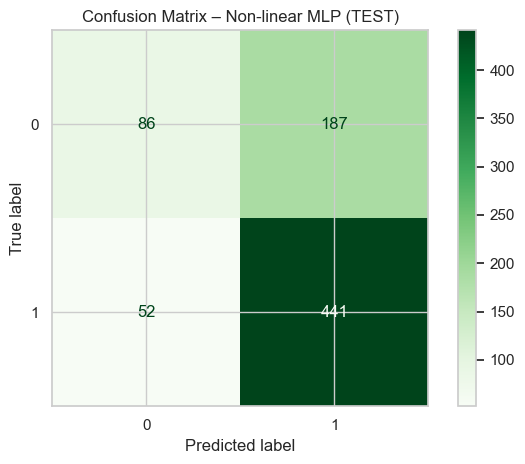

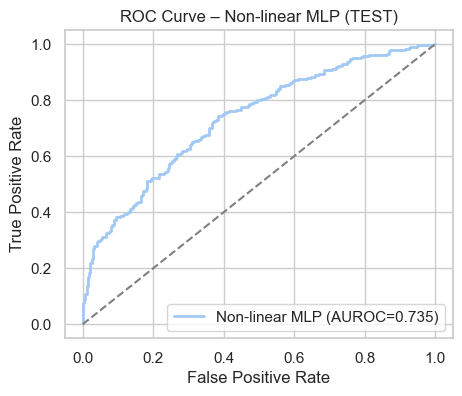

In [54]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_nl)).plot(cmap="Greens")
plt.title("Confusion Matrix – Non-linear MLP (TEST)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_nl)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"Non-linear MLP (AUROC={roc_auc_score(y_test, y_proba_nl):.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Non-linear MLP (TEST)")
plt.legend()
plt.show()

### 3.3 Comparison Between Linear & Non-linear

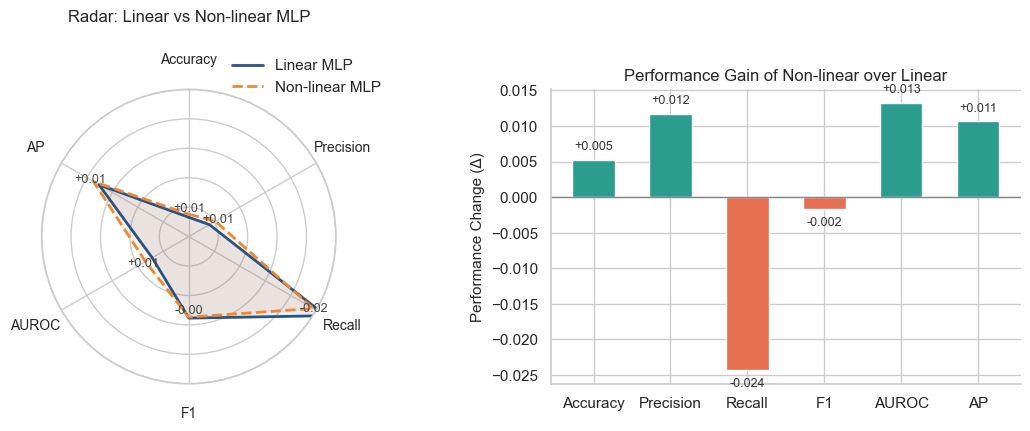

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# data
metrics = comparison_df["Metric"].tolist()
vals_lin = comparison_df["Linear MLP"].to_numpy()
vals_nl  = comparison_df["Non-linear MLP"].to_numpy()
deltas   = comparison_df["Δ (Non-linear - Linear)"].to_numpy()

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]
vals_lin_radar = np.r_[vals_lin, vals_lin[:1]]
vals_nl_radar  = np.r_[vals_nl,  vals_nl[:1]]

fig = plt.figure(figsize=(11, 4.5))
gs = fig.add_gridspec(1, 2, width_ratios=[1.05, 1.15])

# Radar
ax0 = fig.add_subplot(gs[0,0], projection='polar')
ax0.plot(angles, vals_lin_radar, color="#2C5282", lw=2, label="Linear MLP")
ax0.plot(angles, vals_nl_radar, color="#ED8936", lw=2, ls="--", label="Non-linear MLP")
ax0.fill(angles, vals_lin_radar, color="#2C5282", alpha=0.10)
ax0.fill(angles, vals_nl_radar, color="#ED8936", alpha=0.10)

ax0.set_ylim(0.65, 0.90)
ax0.set_theta_offset(np.pi / 2)   
ax0.set_theta_direction(-1)       
ax0.set_yticklabels([])

ax0.set_xticks(np.linspace(0, 2*np.pi, len(metrics), endpoint=False))
ax0.set_xticklabels(metrics, fontsize=10, fontweight='medium', y=-0.05)

# Δ label
for a, v_lin, v_nl in zip(angles[:-1], vals_lin, vals_nl):
    offset = 0.012 if v_nl > v_lin else -0.012
    ax0.text(a, (v_lin + v_nl)/2 + offset, f"{(v_nl - v_lin):+0.02f}",
             ha="center", va="center", fontsize=9, color="#444")

ax0.set_title("Radar: Linear vs Non-linear MLP", fontsize=12, pad=22)
ax0.legend(loc="upper right", bbox_to_anchor=(1.2, 1.15), frameon=False)

# Bar Δ
ax1 = fig.add_subplot(gs[0,1])
colors = np.where(deltas >= 0, "#2A9D8F", "#E76F51")
bars = ax1.bar(metrics, deltas, color=colors, width=0.55)
ax1.axhline(0, color="#888", lw=1)

for rect, d in zip(bars, deltas):
    ax1.text(rect.get_x() + rect.get_width()/2, 
             rect.get_height() + (0.001 if d >= 0 else -0.001),
             f"{d:+.3f}", ha="center", va="bottom" if d>=0 else "top",
             fontsize=9, color="#333")

ax1.set_ylabel("Performance Change (Δ)", fontsize=11)
ax1.set_title("Performance Gain of Non-linear over Linear", fontsize=12)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

### 3.4 Analytical Discussion and Justification

I introduced non-linearity to the best-performing MLP architecture **(32,16)** using the **ReLU** activation function.  
ReLU was chosen because it introduces sparse and efficient non-linear transformations, helping the network capture complex feature interactions while avoiding vanishing gradients and maintaining fast convergence.

Quantitatively, introducing ReLU led to a **+0.013 AUROC** and **+0.011 AP** improvement over the linear MLP (from 0.722 → 0.735 and 0.826 → 0.837).  
Precision also improved slightly (+0.012), while recall decreased marginally (−0.024), indicating a small shift toward higher confidence but fewer positive predictions.  
The F1-score remained almost unchanged (−0.002), confirming a stable balance between sensitivity and precision.  
This consistency suggests that the model gained a modest ability to refine its decision boundary without overfitting.

Overall, these results imply that the dataset exhibits **moderate pattern complexity**—the predictive structure is *mostly linearly separable* with only limited non-linear interactions.  
ReLU successfully enhances boundary flexibility but does not drastically alter performance, meaning the clinical variables already encode strong linear signals.  
Therefore, adding more non-linearity would likely increase variance without meaningful generalization benefits.